# Пример стекинга

2017, Александр Дьяконов

In [1]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np


# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
figsize(12, 9)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Vernada' # Ubuntu

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

# чтобы был русский шрифт
from matplotlib import rc
 
font = {'family': 'Vernada', #Droid Sans
        'weight': 'normal'}
rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


### Авторская реализация стекинга

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

### Отрисовка признаковых пространств

In [3]:
from sklearn.metrics import roc_auc_score

def run_and_plot(clf, X, y, label):
    # plt.figure(figsize=(6, 5))
    
    a = clf.predict(X)
    
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

    
    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3) # plt.cm.Blues_r cmap=plt.cm.Blues_r)
    #a_ = plt.contour(xx, yy, Z, levels=[threshold], linewidths=1, colors='black')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='#CCDDFF')
    
    # не всё... :100
    plt.scatter(X[:300, 0], X[:300, 1], c=y[:300], s=20, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    # plt.axis('tight')
    plt.axis('off')
    plt.title(label)

### Модельная задача

findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.


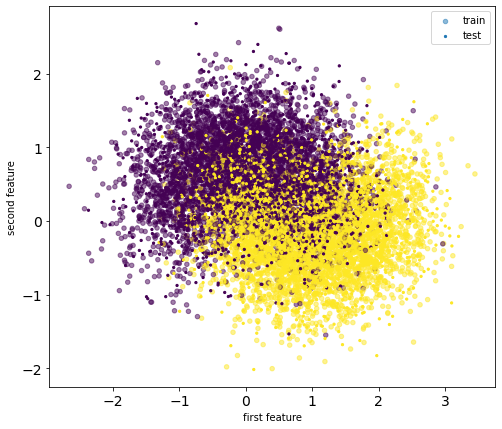

In [4]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification

X, y = make_moons(10000, noise=0.5) #X1, y1 = make_classification(100)


train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, random_state=1999)

plt.figure(figsize=(8, 7))
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=20, alpha=0.5, label='train')
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=5, alpha=1.0, label='test')
plt.xlabel("first feature")
plt.ylabel("second feature")
plt.legend()
plt.show()

### Базовые алгоритмы

3NN AUC-ROC  = 0.8408978062702503
10NN AUC-ROC  = 0.8841076279349709
ridge-0.01 AUC-ROC  = 0.8845828152872527
ridge-1.1 AUC-ROC  = 0.8845819262557238
ridge-100.1 AUC-ROC  = 0.8845352521004481
rf-d1 AUC-ROC  = 0.7845714356836808
rf-d5 AUC-ROC  = 0.897838719901282
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
gbm-d2 AUC-ROC  = 0.8992044945877984
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
gbm-d5 AUC-ROC  = 0.8937025007123366


findfont: Font family ['Vernada'] not found. Falling back to DejaVu Sans.


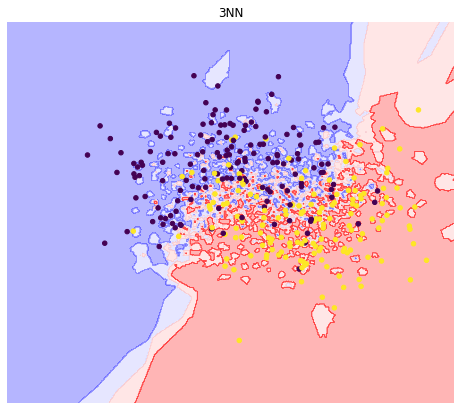

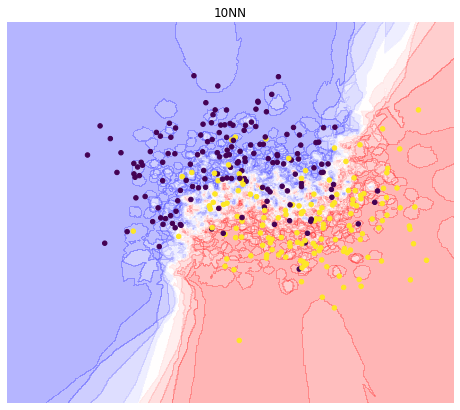

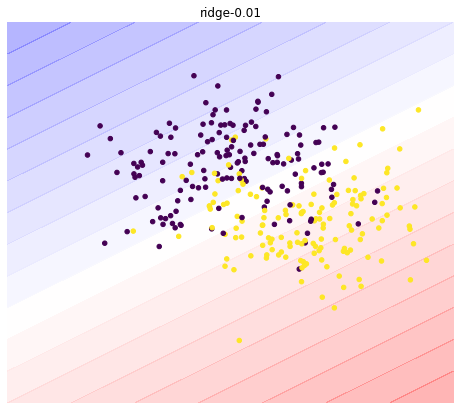

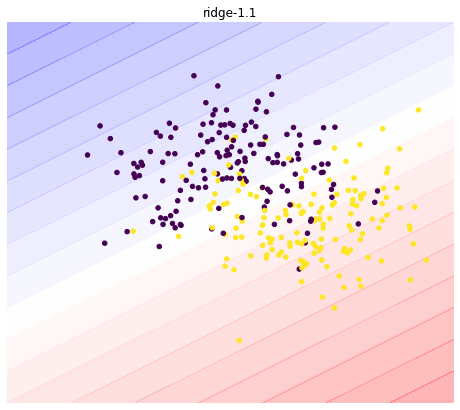

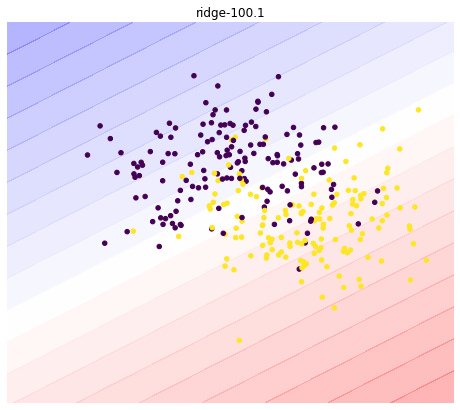

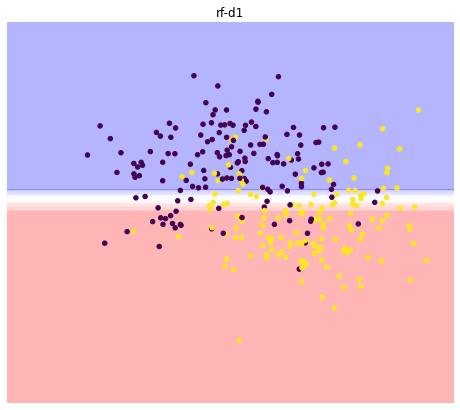

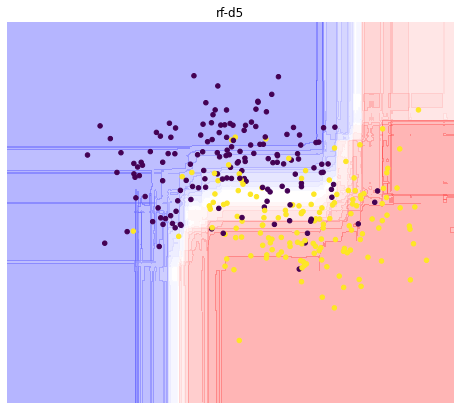

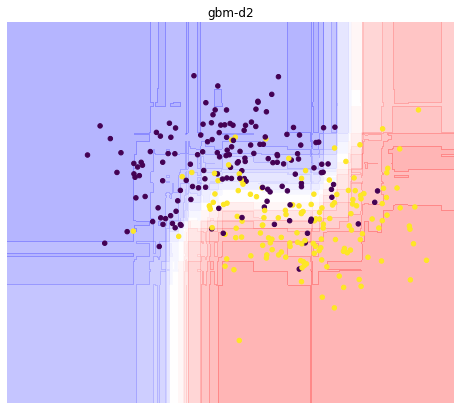

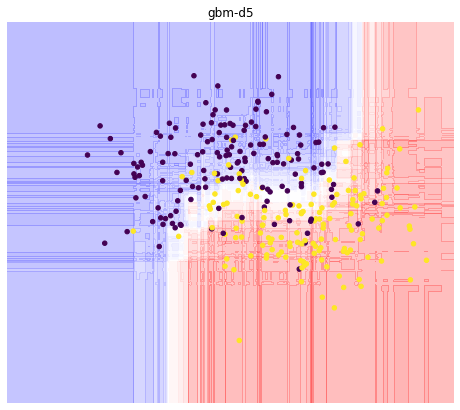

In [6]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

knn1 = KNeighborsRegressor(n_neighbors=3)
knn1.fit(train_X, train_y)
run_and_plot(knn1, test_X, test_y, '3NN')

knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(train_X, train_y)
run_and_plot(knn2, test_X, test_y, '10NN')


rg0 = Ridge(alpha=0.01)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')

rg1 = Ridge(alpha=1.1)
rg1.fit(train_X, train_y)
run_and_plot(rg1, test_X, test_y, 'ridge-1.1')

rg2 = Ridge(alpha=100.1)
rg2.fit(train_X, train_y)
run_and_plot(rg2, test_X, test_y, 'ridge-100.1')


rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf1.fit(train_X, train_y)
run_and_plot(rf1, test_X, test_y, 'rf-d1')

rf2 = RandomForestRegressor(n_estimators=100, max_depth=5)
rf2.fit(train_X, train_y)
run_and_plot(rf2, test_X, test_y, 'rf-d5')


gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=2, n_estimators=200, nthread=-1, objective='regression')    
gbm1.fit(train_X, train_y)
run_and_plot(gbm1, test_X, test_y, 'gbm-d2')

gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=5, n_estimators=200, nthread=-1, objective='regression')    
gbm2.fit(train_X, train_y)
run_and_plot(gbm2, test_X, test_y, 'gbm-d5')

### Запускаем блендинг и стекинг

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
1-stacking AUC-ROC  = 0.8971990617161242
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
2-stacking AUC-ROC  = 0.8992216084447328


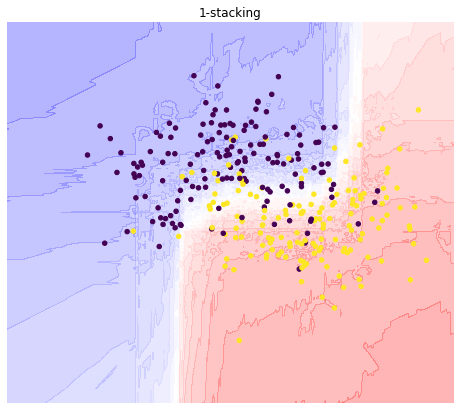

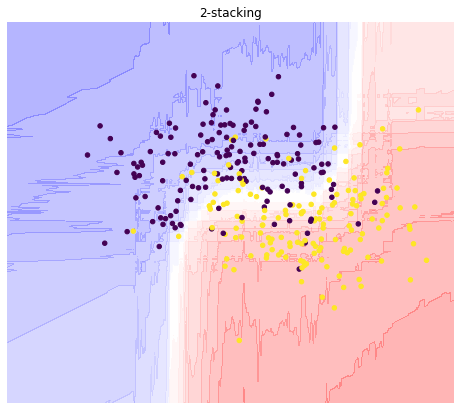

In [7]:
models = [knn1, knn2,rg1, rg2, rf1, rf2, gbm1, gbm2] # , rf3
ens_model = Ridge()
s1 = DjStacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking')


s2 = DjStacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s1, test_X, test_y, '2-stacking')

# 3NN AUC-ROC  = 0.775973303671
# 5NN AUC-ROC  = 0.807764182425
# 10NN AUC-ROC  = 0.832080088988
# 0-ridge AUC-ROC  = 0.860778642937
# 1-ridge AUC-ROC  = 0.860912124583
# 10-ridge AUC-ROC  = 0.860556173526
# 1-rf AUC-ROC  = 0.791879866518
# 3-rf AUC-ROC  = 0.840622914349
# 5-rf AUC-ROC  = 0.848743047831
# 1-stacking AUC-ROC  = 0.855884315907
# 2-stacking AUC-ROC  = 0.852413793103

### Несколько блендингов подряд

In [8]:
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)
s1 = DjStacking(models, ens_model)
a = 0
e = []
for t in range(10):
    s1.fit(train_X, train_y, p=0.4)
    a += s1.predict(test_X, train_y)
    
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.8979422920744171
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
0.8989753467111834
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves a

In [9]:
e4 = e

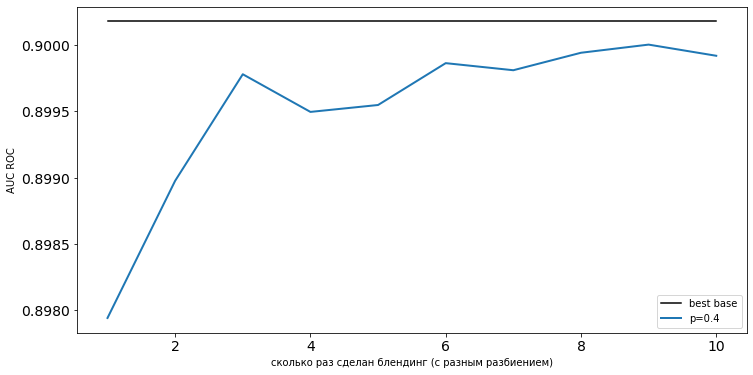

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,11), 0.900175155867 + 0*np.arange(1,11), c='black', label='best base')
#plt.plot(np.arange(1,11), e1, label='p=0.1', lw=2)
#plt.plot(np.arange(1,11), e2, label='p=0.2', lw=2)
#plt.plot(np.arange(1,11), e3, label='p=0.3', lw=2)
plt.plot(np.arange(1,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'сколько раз сделан блендинг (с разным разбиением)')
plt.ylabel('AUC ROC')
plt.legend()

### Варьируем число фолдов

In [11]:
# models = [knn3, knn5, knn10, rg0, rg1, rg2, rf1, rf2, rf3]
ens_model = Ridge(0.001)

s1 = DjStacking(models, ens_model)
a = 0
e = []
for t in range(2, 11):
    s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
    a = s1.predict(test_X, train_y)
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8992073839402676
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8993082890188159
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8993656315524401
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.899341183185391
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8994096386131285
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8992593922847177
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
0.8994327534328842
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 wil

In [12]:
e1 = e

NameError: name 'e2' is not defined

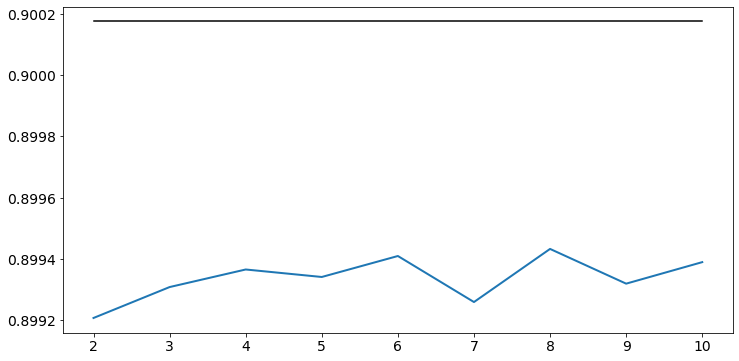

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,11), 0.900175155867 + 0*np.arange(2,11), c='black', label='best base')
plt.plot(np.arange(2,11), e1, label='err=0.0', lw=2)
#plt.plot(np.arange(2,11), e3, label='err=0.01', lw=2)
plt.plot(np.arange(2,11), e2, label='err=0.03', lw=2)
# plt.plot(np.arange(2,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'число фолдов')
plt.ylabel('AUC ROC')
plt.legend()

### Просто для визуализации

In [ ]:
tmp = [('3NN', 0.83541103796),
       ('5NN', 0.854724379878),
       ('10NN', 0.874500610889),
       ('0-ridge', 0.883067503586),
       ('1-ridge', 0.883065725807),
       ('10-ridge', 0.88306217025),
       ('1-rf', 0.773247232554),
       ('3-rf', 0.878800390578),
       ('5-rf', 0.893922841743),
       ('blending', 0.893879508391),
       ('stacking', 0.89432173081)]


xticks = [x[0] for x in tmp]
aucs = [x[1] for x in tmp]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(aucs)), aucs, color='#0000AA', label=u'алгоритмы')
plt.xticks(np.arange(len(aucs))+0.5, xticks, rotation=45)

plt.bar([9, 10], [0.891809729693, 0.890628395835], color='#AA0000', label=u'после удаления лучшего')


plt.xlim([0, 11])
plt.ylim([0.75, 0.9])
plt.ylabel('AUC ROC')
plt.legend(loc=3)